In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from PIL import Image
from torch.utils.data import ConcatDataset, DataLoader
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Custom Dino and Classifier Imports
from dino_utils import prepare_data, Categories_Dataset
from dino_utils import ClassifierModel, evaluate_model, train_model
from dino_utils import set_device

Using mps as device
Using mps as device


/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/swiglu_ffn.py:51: UserWarning: xFormers is not available (SwiGLU)
  warnings.warn("xFormers is not available (SwiGLU)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/attention.py:33: UserWarning: xFormers is not available (Attention)
  warnings.warn("xFormers is not available (Attention)")
/Users/maltegenschow/Documents/Uni/Thesis/Thesis/dinov2/dinov2/layers/block.py:40: UserWarning: xFormers is not available (Block)
  warnings.warn("xFormers is not available (Block)")


In [2]:
import platform
import os
if platform.system() == 'Darwin':
    DATA_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync"
    ROOT_PATH = "/Users/maltegenschow/Documents/Uni/Thesis/Thesis"
elif platform.system() == 'Linux':
    DATA_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Data.nosync"
    ROOT_PATH = "/pfs/work7/workspace/scratch/tu_zxmav84-thesis/Thesis"

current_wd = os.getcwd()

In [3]:
target = 'sleeve_length'
fake_data_name = 'hyperstyle_embeddings'
retrain = False

### 1. Prepare Data

In [4]:
train_real, test_real = prepare_data(target, 'real_images_embeddings')
train_fake, test_fake = prepare_data(target, fake_data_name)

# Combine real and fake data
train = ConcatDataset([train_real, train_fake])
test = ConcatDataset([test_real, test_fake])

print(f"Target: {train_real.target}")
print(f"\tNumber of classes: {len(train_real.id2label)}")

print(f"\tNumber of training samples: {len(train)}")
print(f"\tNumber of testing samples: {len(test)}")

Target: sleeve_length
	Number of classes: 11
	Number of training samples: 22476
	Number of testing samples: 5620


### 2. Training

In [5]:
## Model Parameters
embeddings_shape = train_real[0][0].shape[0]
num_classes = len(train_real.id2label)

## Training Hyperparameters
NUM_EPOCHS = 30
BATCH_SIZE = 128
LR = 5e-4
loss_fn = nn.CrossEntropyLoss()

## Initialize Model and Optimizer
device = set_device()
model = ClassifierModel(embeddings_shape, num_classes)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=LR)

model_save_path = f"{DATA_PATH}/Models/Assessor/DinoV2/Classifier/{target}_{fake_data_name}.pt"

Using mps as device


Initial Train Accuracy: 0.04765082754938601, Initial Test Accuracy: 0.050711743772241996
Epoch 1/30, Loss: 0.5583123564720154, Train Accuracy: 0.7591208400071187, Test Accuracy: 0.7400355871886121
Epoch 2/30, Loss: 0.7213740348815918, Train Accuracy: 0.7888414308595836, Test Accuracy: 0.7633451957295374
Epoch 3/30, Loss: 0.6331017017364502, Train Accuracy: 0.7829684997330486, Test Accuracy: 0.755338078291815
Epoch 4/30, Loss: 0.6779255867004395, Train Accuracy: 0.8173162484427834, Test Accuracy: 0.7779359430604982
Epoch 5/30, Loss: 0.48845240473747253, Train Accuracy: 0.8269264993771134, Test Accuracy: 0.7754448398576512
Epoch 6/30, Loss: 0.48748403787612915, Train Accuracy: 0.8403185620217121, Test Accuracy: 0.7893238434163701
Epoch 7/30, Loss: 0.5416430830955505, Train Accuracy: 0.8494838939313045, Test Accuracy: 0.7838078291814946
Epoch 8/30, Loss: 0.5474310517311096, Train Accuracy: 0.8551788574479445, Test Accuracy: 0.7909252669039146
Epoch 9/30, Loss: 0.42041200399398804, Train A

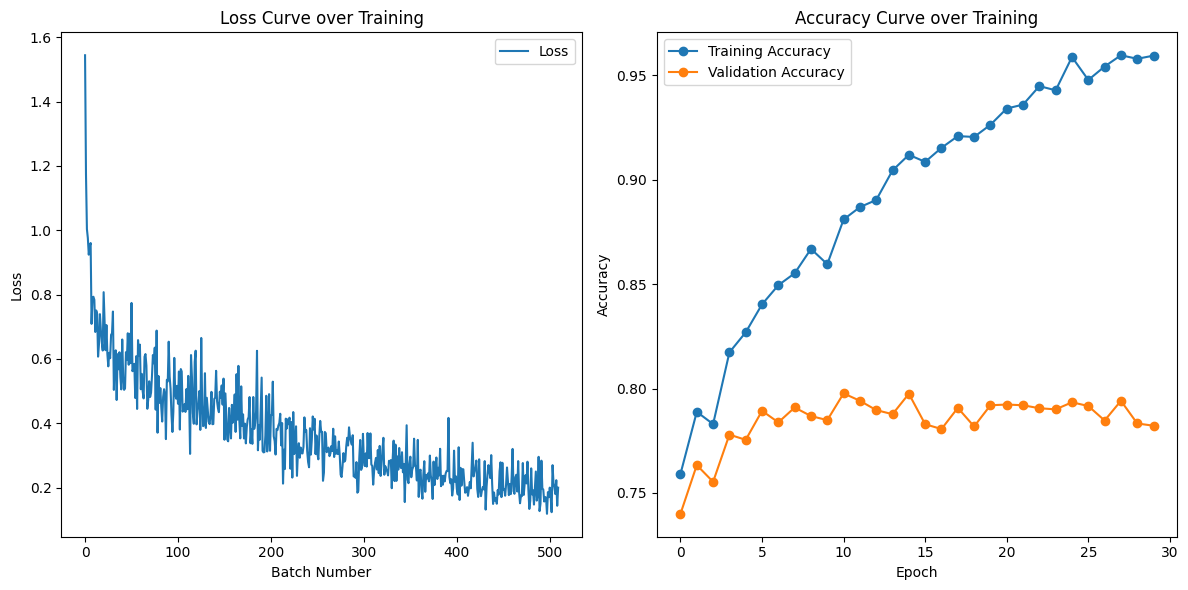

In [6]:
# Create dataloaders
train_loader = DataLoader(train, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(test, batch_size=BATCH_SIZE, shuffle=True)
if retrain or not os.path.exists(model_save_path):
    train_model(model, NUM_EPOCHS, optimizer, loss_fn, train_loader, test_loader, model_save_path, device, log_every=10)
else:
    model = torch.load(model_save_path, map_location = 'cpu')

### 3. Evaluation

In [7]:
print("Overall Accuracy:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test), device)}")

print("Accuracy on real data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_real), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_real), device)}")

print("Accuracy on fake data:")
print(f"\tTraining Set: {evaluate_model(model, DataLoader(train_fake), device)}")
print(f"\tTesting Set: {evaluate_model(model, DataLoader(test_fake), device)}")

Overall Accuracy:
	Training Set: 0.9593788930414665
	Testing Set: 0.7822064056939502
Accuracy on real data:
	Training Set: 0.9664531055347927
	Testing Set: 0.7886120996441282
Accuracy on fake data:
	Training Set: 0.9523046805481402
	Testing Set: 0.7758007117437722


#### Top N Accuracy

In [8]:
real_loader = DataLoader(ConcatDataset([train_real, test_real]), batch_size=BATCH_SIZE, shuffle=False)
fake_loader = DataLoader(ConcatDataset([train_fake, test_fake]), batch_size=BATCH_SIZE, shuffle=False)

In [9]:
def get_top_n_predictions(loader, n):
    predictions = {}

    for embeddings, labels, sku in loader:
        output = model(embeddings.to(device))
        prob, predicted = torch.topk(torch.softmax(output, 1), n)

        for i in range(len(predicted)):
            predictions[sku[i]] = [train_real.id2label[labels[i].item()]] + [train_real.id2label[predicted[i][j].item()] for j in range(n)] + [prob[i][j].item() for j in range(n)]

    df = pd.DataFrame(predictions).T.reset_index()
    df.columns = ['sku'] + ['target'] + [f'pred_{i}' for i in range(n)] + [f'prob_{i}' for i in range(n)]

    df['top1_correct'] = df['target'] == df['pred_0']
    for i in range(1, n):
        df[f'top{i+1}_correct'] = df[f'top{i}_correct'] | (df['target'] == df[f'pred_{i}'])
    return df


In [10]:
real_predictions = get_top_n_predictions(real_loader, 3)
fake_predictions = get_top_n_predictions(fake_loader, 3)

real_predictions['dataset'] = real_predictions.sku.apply(lambda x: 'train' if x in train_real.df.sku.to_list() else 'test')
fake_predictions['dataset'] = fake_predictions.sku.apply(lambda x: 'train' if x in train_fake.df.sku.to_list() else 'test')

In [11]:
print("Real Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {real_predictions[real_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

print("Reconstructed Images:")
for dataset in ['train', 'test']:
    print(f"\t{dataset.capitalize()} Set:")
    for i in range(3):
        print(f"\t\tTop {i+1}: {fake_predictions[fake_predictions.dataset == dataset][f'top{i+1}_correct'].mean()}")

Real Images:
	Train Set:
		Top 1: 0.9664531055347927
		Top 2: 0.9986652429257875
		Top 3: 0.9999110161950525
	Test Set:
		Top 1: 0.7886120996441282
		Top 2: 0.9580071174377224
		Top 3: 0.9868327402135232
Reconstructed Images:
	Train Set:
		Top 1: 0.9523046805481402
		Top 2: 0.995906744972415
		Top 3: 0.9995550809752625
	Test Set:
		Top 1: 0.7758007117437722
		Top 2: 0.9551601423487545
		Top 3: 0.9868327402135232


In [12]:
print('Real Images:')
display(real_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False))

print('Reconstructed Images:')
fake_predictions.groupby('target').top1_correct.mean().sort_values(ascending=False)

Real Images:


target
Spaghetti straps         0.980913
Long                     0.973997
Short                    0.960076
Strapless                0.937888
Sleeveless               0.931402
3/4 length               0.919009
Sleeveless, strapless    0.906780
Extra short              0.862348
Elbow length             0.861304
Mixed                    0.853659
Extra long               0.650435
Name: top1_correct, dtype: float64

Reconstructed Images:


target
Spaghetti straps         0.976763
Long                     0.973721
Short                    0.958175
Strapless                0.937888
Extra short              0.906883
3/4 length               0.898929
Sleeveless, strapless    0.898305
Sleeveless               0.892530
Mixed                    0.798780
Elbow length             0.797503
Extra long               0.600000
Name: top1_correct, dtype: float64

In [13]:
pd.crosstab(real_predictions.target, real_predictions.pred_0)

pred_0,3/4 length,Elbow length,Extra long,Extra short,Long,Mixed,Short,Sleeveless,"Sleeveless, strapless",Spaghetti straps,Strapless
target,,,,,,,,,,,
3/4 length,1373,36,4,0,76,0,4,1,0,0,0
Elbow length,18,621,0,0,2,0,80,0,0,0,0
Extra long,3,1,374,0,196,0,1,0,0,0,0
Extra short,0,0,0,639,0,2,86,13,0,1,0
Long,36,5,53,0,3521,0,0,0,0,0,0
Mixed,2,0,0,1,4,140,4,0,2,11,0
Short,3,57,0,33,2,1,2525,4,0,4,1
Sleeveless,0,1,0,47,0,1,7,2444,9,114,1
"Sleeveless, strapless",0,0,0,1,0,0,0,5,107,4,1


### Check some misclassified examples

In [14]:
def display_missclassified_samples(miss, num_samples=5):
    sample = miss.sample(num_samples)
    fig, ax = plt.subplots(1, num_samples, figsize=(5 * num_samples, 10))

    for i in range(num_samples):
        sku = sample.iloc[i].sku
        img_path = f"{DATA_PATH}/Generated_Images/hyperstyle/inference_results/4/{sku}.jpg"
        img = Image.open(img_path)
        ax[i].imshow(img)

        # Construct title string with predictions and their probabilities
        title_text = f"SKU: {sku}\nTarget: {sample.iloc[i].target}"
        for j in range(3):  # Assuming there are always three predictions to display
            pred_col = f'pred_{j}'
            prob_col = f'prob_{j}'
            title_text += f"\nPrediction {j + 1}: {sample.iloc[i][pred_col]} ({np.round(sample.iloc[i][prob_col], 2)})"

        ax[i].set_title(title_text)
        ax[i].axis('off')

    plt.tight_layout()
    plt.show()


FileNotFoundError: [Errno 2] No such file or directory: '/Users/maltegenschow/Documents/Uni/Thesis/Data.nosync/Generated_Images/hyperstyle/inference_results/4/LQQ21C02W-M11.jpg'

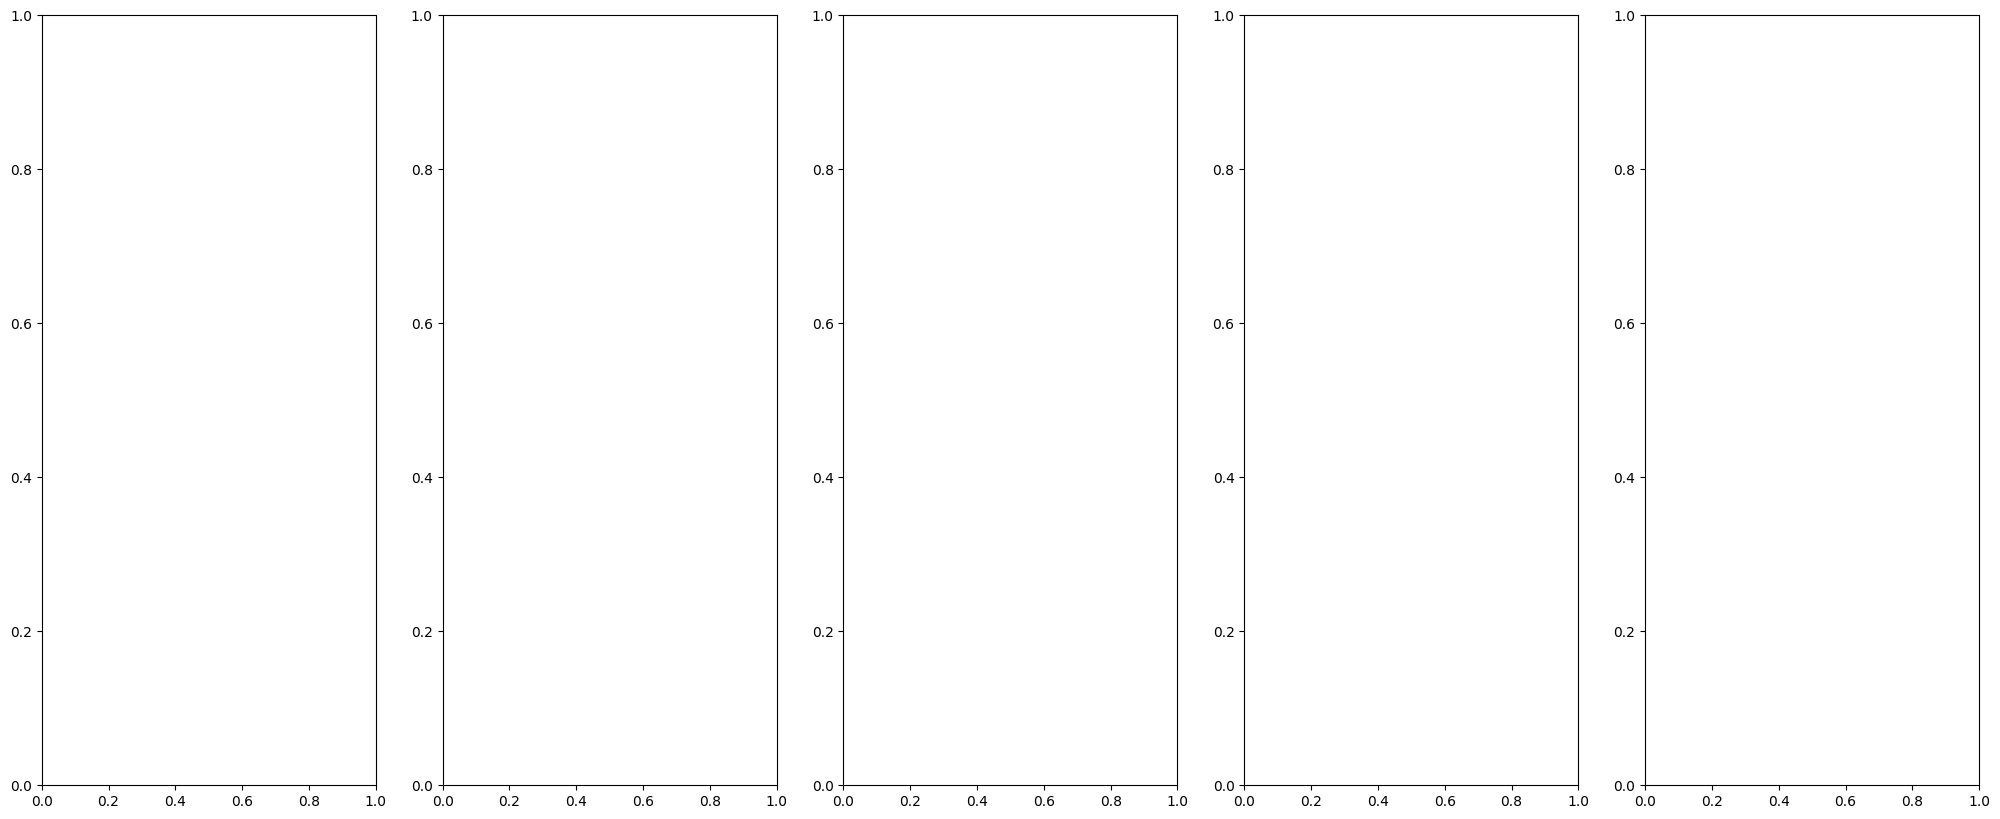

In [15]:
miss = fake_predictions[fake_predictions.target != fake_predictions.pred_0]
display_missclassified_samples(miss, 5)